## Historical Prices of Cryptocurrency
Ashwin Jeyaseelan, Evan Kerekanich

### Introduction
Recently, a cryptocurrency called bitcoin has become a hot topic, but what is it? Bitcoin is the first digital currency which allows the transfer of currency between people without a third party. It was created in 2009 by an unknown person with the alias, Satoshi Nakamoto. It can be used to buy merchandice just like normal currency. Surprisingly, bitcoin has built up a large enough community that markets run competitions where participants are rewarded with bitcoins in exchange of solving complex math puzzles. 

The purpose of this tutorial is to understand the trend of bitcoin prices to help users decide if it's worth participating with. We will show how to gather, parse, analyze, and conduct hypothesis testing on the data. Finally, we will use machine learning to provide analysis about the bitcoin prices.

### Getting Started 
First download the bitcoin data from: https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima/data. Next we will load the bitcoin data file with the library, Pandas. This data contains information about 1-minute bitcoin exchanges from Jan 2012 to October 2017. 

#### Required Tools:
* Python 3.5+
* Pandas
* numpy 
* matplotlib 


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm

# Load data:
table = pd.read_csv("bitcoin-historical-data/btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv")
# Print the first 5 rows of our data:
table.head()

/Users/ashwinjeyaseelan/Documents/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325292180,4.247,4.247,4.247,4.247,0.4,1.6988,4.247
1,1325292240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325292300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325292360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325292420,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at our data, we can see the features: Timestamp (unix time), open (opening or starting price of the bitcoin), high (highest price in the minute), low (lowest price in the minute), close (the closing price of the bitcoin), volume and the weighted price.

#### Tidying Our Data
In the head of the table, notice that only one of the rows has succificent data to properly analyze the features. We can save space and time by getting rid of rows that are missing data for features.

In [2]:
# drop rows with NaN for any of their features
table = table.dropna()
# view the first 5 rows of the tidy table:
table.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325292180,4.247,4.247,4.247,4.247,0.400000,1.698800,4.247000
138,1325300460,4.100,4.100,4.100,4.100,0.623628,2.556875,4.100000
212,1325304900,4.100,4.100,4.100,4.100,6.503072,26.662595,4.100000
284,1325309220,4.045,4.045,4.044,4.044,2.379300,9.624254,4.044994
311,1325310840,4.044,4.044,4.011,4.011,0.896400,3.607223,4.024122


### Data Analysis
Now that we've prepared our data, we can analyze it. Let's prepare plots to view the prices by days, months, and years.


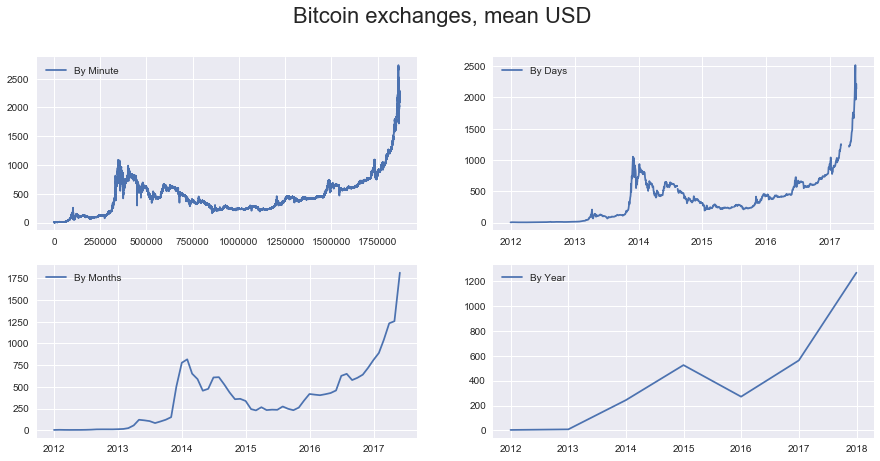

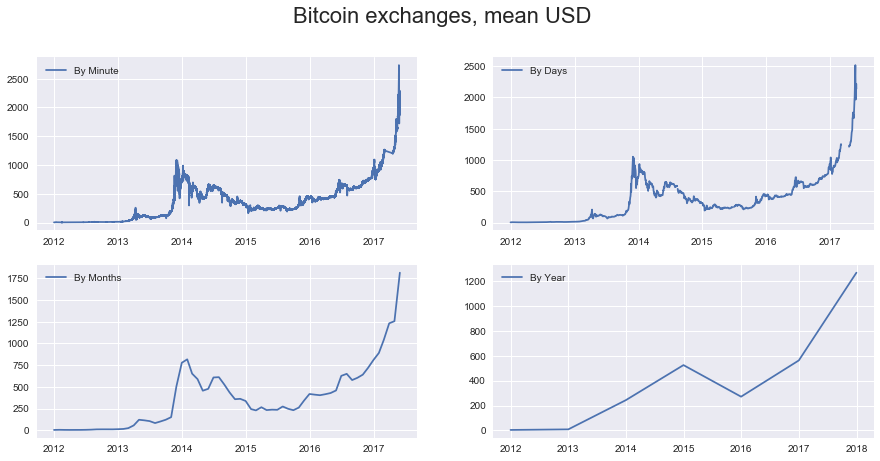

In [167]:
fig = plt.figure(figsize=[15,7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

# minute plot:
plt.subplot(221)
plt.plot(table.Weighted_Price, label='By Minute')
plt.legend()

table.Timestamp = pd.to_datetime(table.Timestamp, unit='s')
table.index = table.Timestamp

# Day plot:
table_day = table.resample('D').mean()
plt.subplot(222)
plt.plot(table_day.Weighted_Price, label='By Days')
plt.legend()

# month plot:
plt.subplot(223)
table_month = table.resample('M').mean()
plt.plot(table_month.Weighted_Price, label='By Months')
plt.legend()

# year plot:
plt.subplot(224)
table_year = table.resample('A-DEC').mean()
plt.plot(table_year.Weighted_Price, label='By Year')
plt.legend()

plt.show()

From looking at the data, we can see that that the price has its first peak around 2015, and rapidly increases after 2016. In the day minute plot, you can see more oscillations in the line. This makes sense, because in the smallest unit of time, the fluctuations reflect how rapidly it changes at every minute. After 2017, the prices of bitcoins increase much faster than in any previous year. 

### Machine Learning
Looking back at our bitcoin exchanges subplots, we can clearly see that the prices aren't increasing linearly over time. The bitcoin prices can be modeled better as a polynomial function of our features. 

#### Neural Network
We will use a neural network to model prices as a function of our seven features. A neural network can model can be used to model non convex functions. As you can see our prices are neither a perfect polynomial function of time nor are they a linear function, which makes a neural network a good choice for our objective. 

A neural network is composed of layers of units, each of which compute a weighted sum of incoming inputs. After applying a function to this weighted sum, known as the activation function, the unit passes its output to the outputs in the next layer. The last unit to receive the outputs of the units in the last layer returns the output. Our goal is to fine tune the weights of the network so our final output is more accurate. 

Think of a neural network as a model that learns from examples. When you initially feed data into the network, it doesn't know anything so it returns random output. Hence, we train the network after it makes a prediction. This is done by comparing the output of the network with the label or correct answer (in our case this will be the price). In order to decrease the loss of the function, we find the weights that minimize our loss. Neural networks train through backpropagation, in which the slope of the loss function with respect to the weights multiplied by the learning rate parameter is subtracted from the weights. The slope is subtracted from the weights so they can travel in the direction opposite of the increasing slope, i.e. down the slope and hopefully towards the minimum point of the funtion. 

In [168]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# create a network with 4 layers
class NeuralNet(nn.Module):
    def __init__(self, num_features):
        super(NeuralNet, self).__init__()
        self.n1 = nn.BatchNorm1d(num_features)
        self.fc1 = nn.Linear(num_features, 100)
        self.n2 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 100)
        self.n3 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 50)
        self.n4 = nn.BatchNorm1d(50)
        self.fc4 = nn.Linear(50, 1)
        
    def forward(self, x):
        out = F.relu(self.fc1(self.n1(x)))
        out = F.relu(self.fc2(self.n2(out)))
        out = F.relu(self.fc3(self.n3(out)))
        out = F.relu(self.fc4(self.n4(out)))
        return out 

# since we have 7 features (excluding our label which is Weighted_price), our input size is 7
net = NeuralNet(7)

Now that we've created our neural network, we can train it on our data. We will use 20% of the data for testing, and 80% for training. 

In [ ]:
# Split the data into training and test data:
table = pd.read_csv("bitcoin-historical-data/btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv")
table = table.dropna()

table = table.reset_index(drop=True)
divider = np.random.rand(len(table)) < 0.8
train_table = table[divider]
test_table = table[~divider]

train_data = train_table.as_matrix().astype('float')
test_data = test_table.as_matrix().astype('float')

# Loss function:
criterion = nn.MSELoss()
# Optimizer: (either use backpropagation or a variant of it to speed learning)
optimizer = torch.optim.Adam(net.parameters(), lr=0.03)

# epochs: how many iterations we want to train for 
num_epochs = 10
# batch size : number of examples we want to use per training update 
batch_size = 800
# number of splits: how many groups of batches we will use:
num_batches = train_data.size // batch_size
# split the data into batches 
batches =  np.array_split(train_data, num_batches)

# Train the model:
for epoch in range(num_epochs):
    for i, batch in enumerate(batches):
        # want all columns except last column for inputs. Convert it to pytorch's Variable 
        inputs = Variable(torch.from_numpy(batch[:,:-1]).float())
        # last column - our price is the label 
        labels = Variable(torch.from_numpy(batch[:,-1]).float()) 
        
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(inputs) # get the output of the network
        
        loss = criterion(outputs, labels) # compute the loss 
        loss.backward() # update the weights of the neural network
        optimizer.step()
        
        if (i+1) % 1000 == 0: # Print out our loss
            print ('Epoch [%d/%d], Batch # [%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, loss.data[0]))


Epoch [1/10], Batch # [1000], Loss: 144.2186
Epoch [1/10], Batch # [2000], Loss: 23.6503
Epoch [1/10], Batch # [3000], Loss: 48.5019
Epoch [1/10], Batch # [4000], Loss: 4.6962
Epoch [1/10], Batch # [5000], Loss: 163.6945
Epoch [1/10], Batch # [6000], Loss: 1.5741
Epoch [1/10], Batch # [7000], Loss: 35.8018


Now that we have trained our neural network model on the 80% of the data, we can test it with the last 20% of the data, known as the testing data. If we want a model that can make better predictions, our goal is to make a model that generalizes well instead of only learning the weights that make it perform well on the training data. 

In [120]:
# test our model:
inputs = Variable(torch.from_numpy(test_data[:,:-1]).float())
labels = Variable(torch.from_numpy(test_data[:,-1]).float()) 
# get the prediction
prediction = net(inputs)
# compare it to labels:


True